## Import Libs

In [46]:
# Reset all variables so that we can 'run all cells' and not get unused variables hanging around
%reset -f

In [47]:
import pandas as pd
import numpy as np
import pytz
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from matplotlib import pyplot as plt
%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.sampledata.autompg import autompg_clean as df
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [48]:
# Should have at least these versions:
pd.__version__    # >= 0.23

'0.23.4'

### Import Data

In [49]:
# TODO: .trim() imported data
excel_file = 'data/Welder_LP_Tanzania_20180910-20180920.xlsx'
df_2min = pd.read_excel(excel_file, sheet_name='Welder_Tanzania LP')
df_2min = df_2min.rename(columns={'Timestamp (GMT)': 'time_gmt', 'Value': 'welder_count'})

# Convert date string to datetime so we can work with timezones
df_2min['time_gmt'] = pd.to_datetime(df_2min['time_gmt'])
df_2min.head()

,time_gmt,welder_count
0,2018-09-08 01:42:30,0
1,2018-09-08 01:44:30,0
2,2018-09-08 01:46:30,0
3,2018-09-08 01:48:30,0
4,2018-09-08 01:50:30,0


In [50]:
df_2min.shape

(9319, 2)

## Convert Timezones

In [51]:
# To see all timezones available (but select only the first 55 to see Africa): 
# pytz.all_timezones[0:55]  

In [52]:
# There was no Tanzania listed. Nairobi is +3 like Tanzania
# There should not be a problem with daylight savings time - neither observe it
tanzania_tz = pytz.timezone('Africa/Nairobi')

In [53]:
df_2min['time_local'] = df_2min['time_gmt'].dt.tz_localize('utc').dt.tz_convert(tanzania_tz)
df_2min.head()

,time_gmt,welder_count,time_local
0,2018-09-08 01:42:30,0,2018-09-08 04:42:30+03:00
1,2018-09-08 01:44:30,0,2018-09-08 04:44:30+03:00
2,2018-09-08 01:46:30,0,2018-09-08 04:46:30+03:00
3,2018-09-08 01:48:30,0,2018-09-08 04:48:30+03:00
4,2018-09-08 01:50:30,0,2018-09-08 04:50:30+03:00


## Filter out on/off welder noise

In [54]:
# If a welder_on_count value is less than 100, it's probably not actual usage. 
# Set anything less than a threshold to zero
noise_threshold = 100

In [77]:
# TODO: change to welder_on_count
df_2min['welder_is_on'] = np.where(df_2min['welder_count'] > noise_threshold, 1, 0 )
df_2min[60:70]

,time_gmt,welder_count,time_local,welder_is_on
60,2018-09-08 03:42:30,15,2018-09-08 06:42:30+03:00,0
61,2018-09-08 03:44:30,3,2018-09-08 06:44:30+03:00,0
62,2018-09-08 03:46:30,2,2018-09-08 06:46:30+03:00,0
63,2018-09-08 03:48:30,18,2018-09-08 06:48:30+03:00,0
64,2018-09-08 03:50:30,22,2018-09-08 06:50:30+03:00,0
65,2018-09-08 03:52:30,0,2018-09-08 06:52:30+03:00,0
66,2018-09-08 03:54:30,417,2018-09-08 06:54:30+03:00,1
67,2018-09-08 03:56:30,0,2018-09-08 06:56:30+03:00,0
68,2018-09-08 03:58:30,0,2018-09-08 06:58:30+03:00,0
69,2018-09-08 04:00:14,0,2018-09-08 07:00:14+03:00,0


In [56]:
df_2min[156:168]

,time_gmt,welder_count,time_local,welder_is_on
156,2018-09-08 06:54:14,0,2018-09-08 09:54:14+03:00,0
157,2018-09-08 06:56:14,0,2018-09-08 09:56:14+03:00,0
158,2018-09-08 06:58:14,0,2018-09-08 09:58:14+03:00,0
159,2018-09-08 07:00:14,0,2018-09-08 10:00:14+03:00,0
160,2018-09-08 07:02:14,0,2018-09-08 10:02:14+03:00,0
161,2018-09-08 07:04:14,311,2018-09-08 10:04:14+03:00,1
162,2018-09-08 07:06:14,2080,2018-09-08 10:06:14+03:00,1
163,2018-09-08 07:08:14,265,2018-09-08 10:08:14+03:00,1
164,2018-09-08 07:10:14,0,2018-09-08 10:10:14+03:00,0
165,2018-09-08 07:12:14,0,2018-09-08 10:12:14+03:00,0


## Utilization per interval

In [57]:
# Assume for any 2 minute logged interval that the actual utilization rate is 25%.
# In other words, in 2 minutes the welder is actually used for 30s.
# We will make this adjustable, along with the voltate and current in the app.
# But it doesn't hurt to hard-code it here - we can ignore it later. 
# Let's make the pattern "magnitude agnostic" so we can preserve the pattern, but apply 
# different voltage and current values to it

# For the welder, the energy load profile will be especially different from the peak power 
# consumed… so let's just make sure we remember that the kWh consumed in the 1-hour timestep 
# is in no way indicative of the peak power drawn during that hour. 
# utilization_while_logged = 0.25

In [58]:
# df_2min['welder_utilization'] = df_2min['welder_is_on'] * utilization_while_logged
# df_2min[60:70]

## Resample 2-min intervals to hourly intevals
Here is a good example of how to resample time-series data: 
https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [59]:
# Convert the dataframe to have a datetime index (instead of a default integer) in order 
# to resample to hourly intervals
df_2min_index = df_2min.set_index('time_local')
df_2min_index[60:67]

,time_gmt,welder_count,welder_is_on
time_local,,,
2018-09-08 06:42:30+03:00,2018-09-08 03:42:30,15,0
2018-09-08 06:44:30+03:00,2018-09-08 03:44:30,3,0
2018-09-08 06:46:30+03:00,2018-09-08 03:46:30,2,0
2018-09-08 06:48:30+03:00,2018-09-08 03:48:30,18,0
2018-09-08 06:50:30+03:00,2018-09-08 03:50:30,22,0
2018-09-08 06:52:30+03:00,2018-09-08 03:52:30,0,0
2018-09-08 06:54:30+03:00,2018-09-08 03:54:30,417,1


In [60]:
# Examples of how to query data based on the new datetime index
# df_2min_index[df_2min_index.index.hour == 2]
# df_2min_index['2018-09-08']
# df_2min_index['2018-09-08':'2018-09-10']

# Every interval within an hour. We will reference this same hour
# later after resampling to show that the sum within the hour add up
df_2min_index['2018-09-08 09:00':'2018-09-08 09:58']

,time_gmt,welder_count,welder_is_on
time_local,,,
2018-09-08 09:00:14+03:00,2018-09-08 06:00:14,0,0
2018-09-08 09:02:14+03:00,2018-09-08 06:02:14,0,0
2018-09-08 09:04:14+03:00,2018-09-08 06:04:14,0,0
2018-09-08 09:06:14+03:00,2018-09-08 06:06:14,0,0
2018-09-08 09:08:14+03:00,2018-09-08 06:08:14,0,0
2018-09-08 09:10:14+03:00,2018-09-08 06:10:14,0,0
2018-09-08 09:12:14+03:00,2018-09-08 06:12:14,1755,1
2018-09-08 09:14:14+03:00,2018-09-08 06:14:14,3321,1
2018-09-08 09:16:14+03:00,2018-09-08 06:16:14,3016,1


In [61]:
# Sum every interval within an hour ('H')
df_hour = df_2min_index.resample('H').sum().drop(columns=['welder_count'])

# The original data had 9319 rows. 
# There are 30 two-minute intervals in an hour.
# 9319 / 30 = 311, which is what the row count should be after resampling from 2min to an hour
df_hour.shape

(311, 1)

In [62]:
# You can see the welder_is_on count is consistent with this same hour range above
df_hour['2018-09-08 09:00':'2018-09-08 09:58']

,welder_is_on
time_local,
2018-09-08 09:00:00+03:00,8


In [63]:
# Add day of week column
df_hour['day_name'] = df_hour.index.day_name()
df_hour['hour'] = df_hour.index.hour
df_hour['day_index'] = df_hour.index.dayofweek
df_hour["day"] = df_hour["day_index"].map(str) + '_' + df_hour["day_name"]

df_hour.sample(10)

,welder_is_on,day_name,hour,day_index,day
time_local,,,,,
2018-09-09 20:00:00+03:00,0,Sunday,20,6,6_Sunday
2018-09-18 04:00:00+03:00,0,Tuesday,4,1,1_Tuesday
2018-09-13 08:00:00+03:00,0,Thursday,8,3,3_Thursday
2018-09-14 01:00:00+03:00,0,Friday,1,4,4_Friday
2018-09-15 04:00:00+03:00,0,Saturday,4,5,5_Saturday
2018-09-19 15:00:00+03:00,0,Wednesday,15,2,2_Wednesday
2018-09-15 08:00:00+03:00,0,Saturday,8,5,5_Saturday
2018-09-19 09:00:00+03:00,0,Wednesday,9,2,2_Wednesday
2018-09-14 17:00:00+03:00,0,Friday,17,4,4_Friday


In [64]:
df_hour.to_csv('data/welder_time_local.csv')

In [65]:
# Mondays start a weekday == 0
# df_mondays = df_hour[df_hour.index.weekday == 0]  
# df_mondays

In [66]:
# df_hour['day_of_week' == 'Monday'].plot()

## Find or Create a representative day for each day of the week
The goal is to find a representative week

Can I create a trellis chart that shows a bar chart for every hour of the day?
* The 10am chart would show a bar for every 10am sample that we have.
* Create a histogram for each hour of the day
* A representative hour would be the mode of the distribution (I think)
* Find the mode for every hour for every day (24x7). This gives the representative week. But... in reality the mode will be zero for most of them. So how do I create this? Some constraints:
** For the rep. week, the mean of every day of the week should match the mean of the samples
** The hourly distribution should match the samples

In [67]:
df_hour.sample(4)

,welder_is_on,day_name,hour,day_index,day
time_local,,,,,
2018-09-17 05:00:00+03:00,0,Monday,5,0,0_Monday
2018-09-17 23:00:00+03:00,0,Monday,23,0,0_Monday
2018-09-12 09:00:00+03:00,0,Wednesday,9,2,2_Wednesday
2018-09-14 05:00:00+03:00,0,Friday,5,4,4_Friday


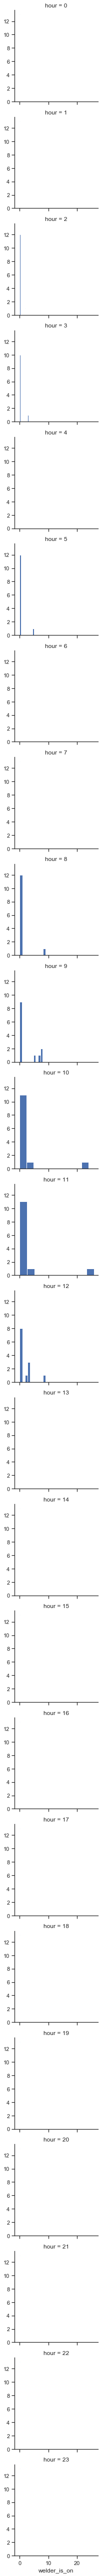

In [68]:
g = sns.FacetGrid(df_hour, row="hour")
g = g.map(plt.hist, "welder_is_on")

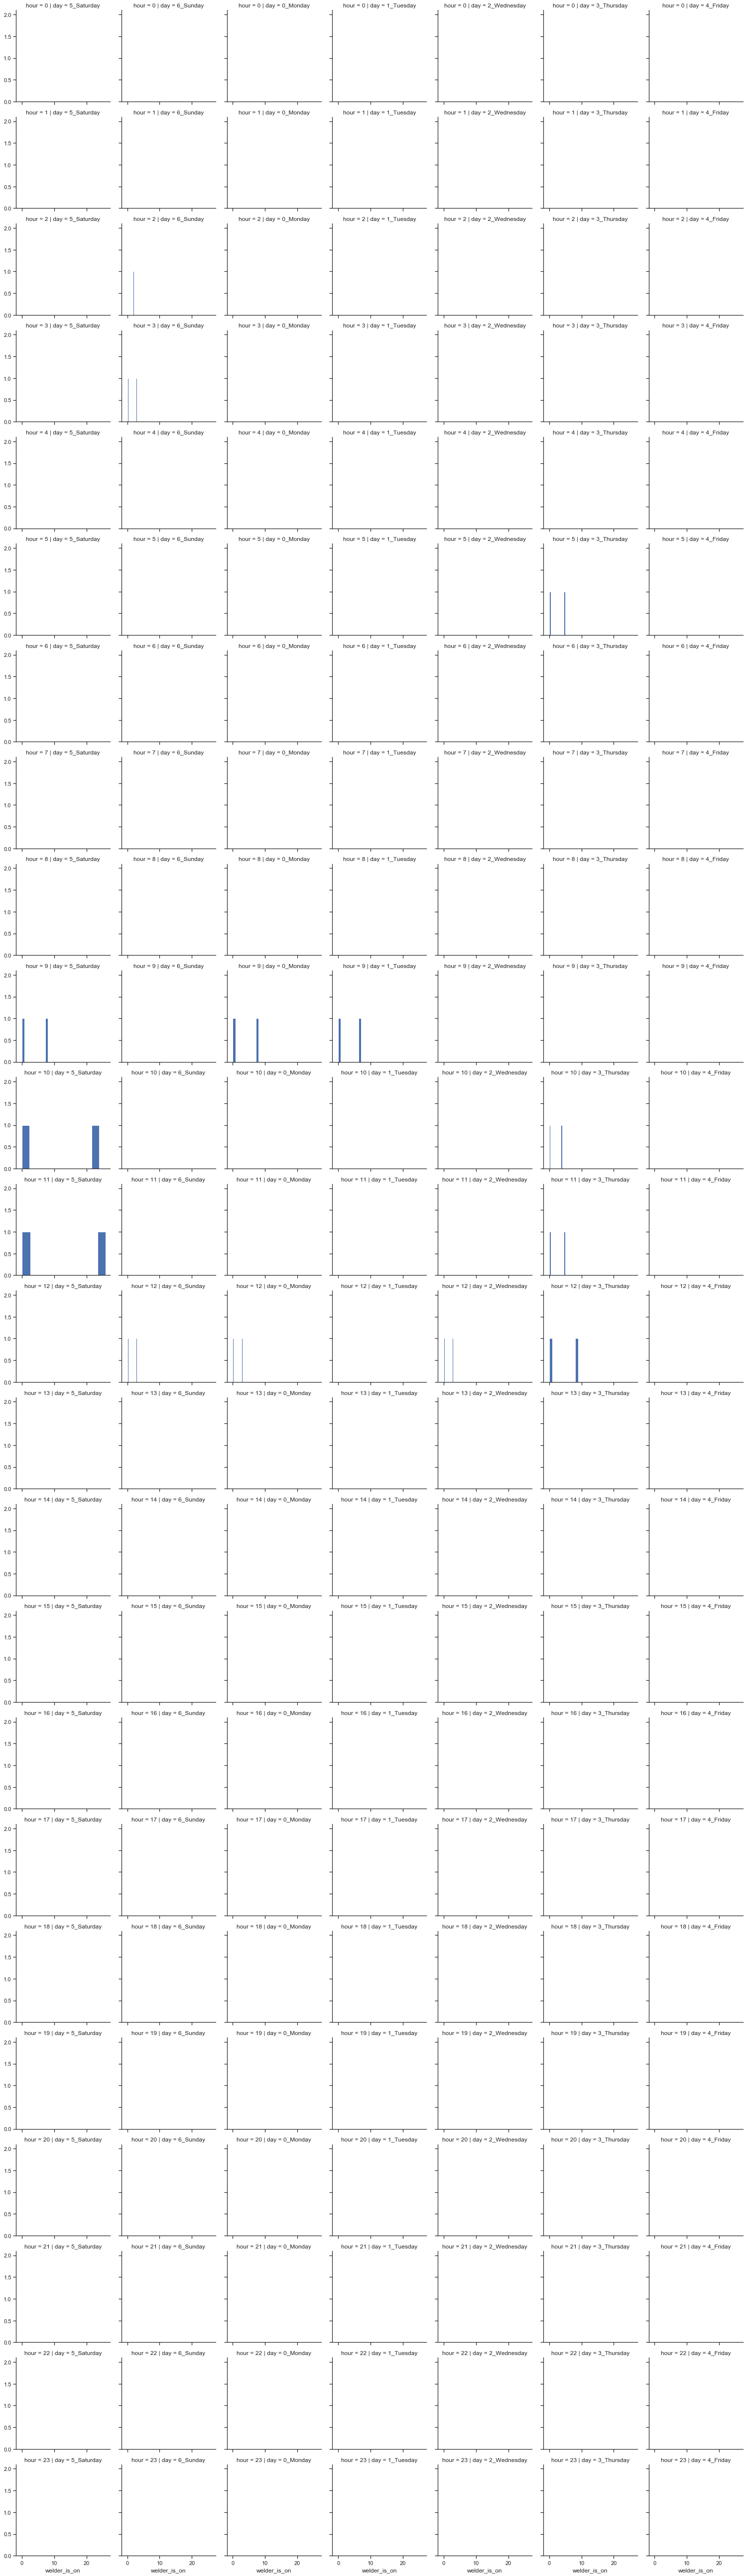

In [69]:
g = sns.FacetGrid(df_hour, col="day", row="hour")
g = g.map(plt.hist, "welder_is_on")

## Loop over each hour

In [70]:
df_hour_0 = df_hour[df_hour.index.hour == 10]
df_hour_0

,welder_is_on,day_name,hour,day_index,day
time_local,,,,,
2018-09-08 10:00:00+03:00,24,Saturday,10,5,5_Saturday
2018-09-09 10:00:00+03:00,0,Sunday,10,6,6_Sunday
2018-09-10 10:00:00+03:00,0,Monday,10,0,0_Monday
2018-09-11 10:00:00+03:00,0,Tuesday,10,1,1_Tuesday
2018-09-12 10:00:00+03:00,0,Wednesday,10,2,2_Wednesday
2018-09-13 10:00:00+03:00,4,Thursday,10,3,3_Thursday
2018-09-14 10:00:00+03:00,0,Friday,10,4,4_Friday
2018-09-15 10:00:00+03:00,0,Saturday,10,5,5_Saturday
2018-09-16 10:00:00+03:00,0,Sunday,10,6,6_Sunday


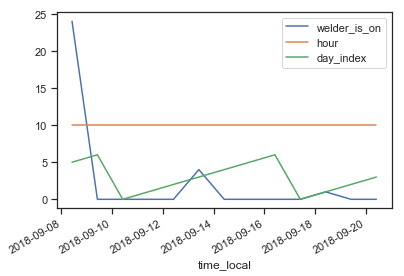

In [71]:
df_hour_0.plot()

In [75]:
# for i in range(0, 23):
#     df_hour[df_hour.index.hour == i].drop(columns=['hour']).plot.bar()

In [76]:
df_hour_10 = df_hour[df_hour.index.hour == 10]
df_hour_10

,welder_is_on,day_name,hour,day_index,day
time_local,,,,,
2018-09-08 10:00:00+03:00,24,Saturday,10,5,5_Saturday
2018-09-09 10:00:00+03:00,0,Sunday,10,6,6_Sunday
2018-09-10 10:00:00+03:00,0,Monday,10,0,0_Monday
2018-09-11 10:00:00+03:00,0,Tuesday,10,1,1_Tuesday
2018-09-12 10:00:00+03:00,0,Wednesday,10,2,2_Wednesday
2018-09-13 10:00:00+03:00,4,Thursday,10,3,3_Thursday
2018-09-14 10:00:00+03:00,0,Friday,10,4,4_Friday
2018-09-15 10:00:00+03:00,0,Saturday,10,5,5_Saturday
2018-09-16 10:00:00+03:00,0,Sunday,10,6,6_Sunday


In [74]:
# plot_data = [go.Bar(x=df_hour_10.index.values, y=df_hour['welder_is_on'])]
# py.iplot(plot_data)